In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/날씨')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import itertools
import pandas as pd
import pandas_profiling
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid' )
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
pyo.init_notebook_mode()


import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import ensemble
from sklearn import metrics
from sklearn.utils.fixes import loguniform
from sklearn import model_selection
#import scikitplot


import statsmodels.api as sm
from scipy import stats

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/날씨/형한결/all.csv')

In [ ]:
def to_datetime(df:pd.DataFrame)->pd.DataFrame:
    df_nfe = df.copy()
    if 'date_time' in df_nfe.columns:
        df_nfe['date_time'] = pd.to_datetime(df_nfe['date_time'])
        #df_nfe['DateTime'] = pd.to_datetime(df_nfe['date_time'])
        df_nfe.set_index('date_time', inplace=True)
    return df_nfe

x_list = ['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14', 'band15', 'band16']
def del_999(df)->pd.DataFrame:
  df_del999 = df.copy()
  for col in x_list:
    df_del999[col] = df_del999[col].replace(-999,np.nan)
  return df_del999

def  spn_split(df:pd.DataFrame,spn_num :int)->pd.DataFrame:
  if 'stn' in df.columns:
    df_stn_num = df.loc[df['stn']==spn_num,:]
    df_stn_num = df_stn_num.drop(['lon','lat','landtype','sateza','height','stn'],axis=1)
    return df_stn_num  

def lag_feature(df:pd.DataFrame,shift_num:int):
  df_lag =df.copy()
  df_lag['uv_lag'+f'{shift_num}'] = df_lag['uv'].shift(shift_num)
  return df_lag
  
def time_feature(df:pd.DataFrame,col:str,max_val:int): #day_max_val = 365
    df_time_feature = df.copy()
    df_time_feature ['minute']=df_time_feature.index.minute
    df_time_feature ['hour']=df_time_feature.index.hour
    df_time_feature ['day']=df_time_feature.index.month
    df_time_feature ['month']=df_time_feature.index.month
    df_time_feature[col + '_sin'] = np.sin(2 * np.pi * df_time_feature[col]/max_val)
    df_time_feature[col + '_cos'] = np.cos(2 * np.pi * df_time_feature[col]/max_val)
    if col+'_sin' not in df.columns:
      concat_df = pd.concat([df,df_time_feature[[col + '_sin']],df_time_feature[[col + '_cos']]],axis=1)
    if 'year' not in df.columns:
      concat_df['year'] = df_time_feature.index.year
      concat_df['year'] = concat_df['year'].replace(2020,0)
      concat_df['year'] = concat_df['year'].replace(2021,1)
    return concat_df
 

def train_test_split(df:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
  train = df.loc[df.index<'2021-07-01 00:00:00']
  test = df.loc[df.index>'2021-08-31 23:50:00']
  return (train, test)



def pps(df:pd.DataFrame,scaler:str):
  standard_scaler = preprocessing.StandardScaler()
  robust_scaler = preprocessing.RobustScaler()
  minmax_scaler = preprocessing.MinMaxScaler()
  normalize_scaler = preprocessing.Normalizer()
  not_uv=[]
  for column in df.columns:
    if column != 'uv':
      not_uv.append(column)
  if scaler == 'standard':
    standard_df = pd.DataFrame(standard_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    standard_df = pd.concat([df[['uv']],standard_df],axis=1)
    return standard_df
  if scaler == 'robust':
    robust_df = pd.DataFrame(robust_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    robust_df = pd.concat([df[['uv']],robust_df],axis=1)
    return robust_df
  if scaler == 'minmax':
    minmax_df = pd.DataFrame(minmax_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    minmax_df = pd.concat([df[['uv']],minmax_df],axis=1)
    return minmax_df
  if scaler == 'normalize':
    normalize_df = pd.DataFrame(normalize_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    normalize_df = pd.concat([df[['uv']],normalize_df],axis=1)
    return normalize_df      




In [ ]:
df = data.copy()
df = to_datetime(df)
df = del_999(df)
df_13 = spn_split(df,13)
df_108 = spn_split(df,108)

In [ ]:
df_13.describe().T

,count,mean,std,min,25%,50%,75%,max
uv,92953.0,1.113406,2.003440,0.00000,0.00000,0.000000,1.400000,12.60000
band1,104060.0,0.100942,0.157443,-0.01133,0.00000,0.009630,0.133690,1.14828
band2,104060.0,0.097044,0.157684,-0.01141,0.00000,0.007980,0.118620,1.15594
band3,104060.0,0.087318,0.158552,-0.01192,0.00000,0.005070,0.084640,1.05588
band4,104060.0,0.100215,0.171888,-0.01197,0.00000,0.005690,0.126290,1.10036
band5,104060.0,0.012935,0.041450,-0.01208,0.00000,0.000300,0.003020,0.58480
band6,104060.0,0.065007,0.103541,-0.01290,-0.00065,0.001930,0.098040,0.71077
band7,104060.0,280.379854,16.792067,203.99058,268.79796,284.092680,292.663570,318.70280
band8,104060.0,237.510908,6.782549,200.76161,233.61643,237.816030,242.233650,260.32530
band9,104060.0,245.511724,8.423918,200.61202,241.41857,246.582080,251.240840,268.39596


In [ ]:
plt.figure(figsize=(12,12))
sns.lineplot(data=df_13,x=df_13.index,y='solarza')

Text(0.5, 1.0, '8/15')

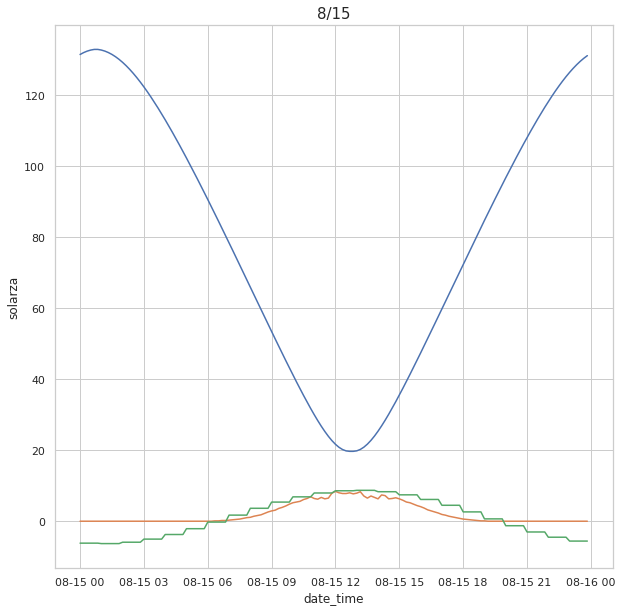

In [ ]:
data= df_13['2020-08-15 00:00:00' : '2020-08-15 23:50:00']
plt.figure(figsize=(10,10))
sns.lineplot(data=data,x=data.index,y='solarza')
sns.lineplot(data=data,x=data.index,y='uv')
sns.lineplot(data=data,x=data.index,y='esr')
plt.title('8/15',fontsize=15)

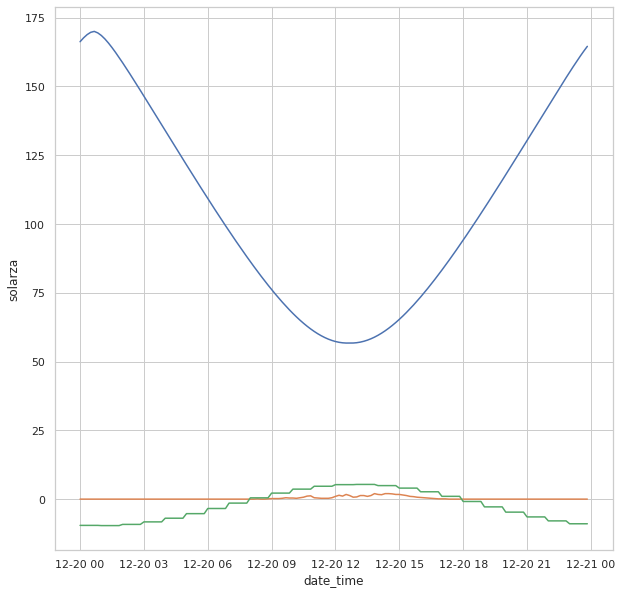

In [ ]:
data= df_13['2020-12-20 00:00:00' : '2020-12-20 23:50:00']
plt.figure(figsize=(10,10))
sns.lineplot(data=data,x=data.index,y='solarza')
sns.lineplot(data=data,x=data.index,y='uv')
sns.lineplot(data=data,x=data.index,y='esr')

1. band 1, 2,3 ,4,6 래그 10~20분 정도? ,band6만따로
2. band 5 제외
3. band 7 변환 or 변환이동
4. band 8 9 10 (서로좀다름) 변환 or 변환이동 #수증기라 이동?
5. ban 11 12 13 15 16 변호나 OR 변환이동



In [ ]:
df_78 = pps(df.loc['2020-07-01 00:00:00':'2020-09-29 23:50:00':],'standard')

In [ ]:
df_78

,uv,stn,lon,lat,band1,band2,band3,band4,band5,band6,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
date_time,,,,,,,,,,,,,,,,,,,,,
2020-07-01 00:00:00,0.0,-3.212261,-1.214477,-2.370964,-0.731564,-0.717937,-0.675026,-0.725493,-0.388112,-0.740884,...,0.463456,0.583503,0.629031,0.677789,0.741402,1.156006,-2.352609,-1.172577,0.050923,-1.913378
2020-07-01 00:00:00,0.0,-0.624450,0.769724,1.392945,-0.734422,-0.717937,-0.676514,-0.724126,-0.388112,-0.746348,...,-1.550779,-1.610355,-1.600899,-1.579879,-1.555753,1.049643,1.374249,-1.067077,-0.918932,0.478345
2020-07-01 00:00:00,0.0,-0.540065,-0.629602,1.240350,-0.731564,-0.715080,-0.669124,-0.722076,-0.388112,-0.746348,...,-1.134920,-1.127964,-1.092750,-1.115969,-1.053166,1.046114,1.243844,-1.064562,0.363710,0.478345
2020-07-01 00:00:00,0.0,-0.427551,-0.876703,1.161478,-0.734422,-0.715080,-0.676514,-0.721393,-0.383059,-0.740884,...,-0.887825,-0.803191,-0.777629,-0.735605,-0.645699,1.047399,1.162057,-1.066027,0.007564,0.478345
2020-07-01 00:00:00,0.0,-0.343166,2.228395,1.164497,-0.734422,-0.715080,-0.676514,-0.723443,-0.388112,-0.740884,...,0.464972,0.653210,0.663389,0.632752,0.631560,1.063487,1.217873,-1.079802,3.325480,1.275586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-29 23:50:00,0.0,0.528814,-0.517713,-0.222608,-0.731564,-0.717937,-0.676514,-0.724810,-0.393165,-0.746348,...,0.562603,0.683970,0.727006,0.773032,0.697235,1.796724,-0.227033,-1.668275,-0.123806,0.478345
2020-09-29 23:50:00,0.0,0.697584,1.092125,-0.441012,-0.731564,-0.715080,-0.685391,-0.724126,-0.393165,-0.740884,...,-0.062796,0.038333,0.045298,0.091260,0.081395,1.817363,-0.440017,-1.692163,0.288210,-0.318896
2020-09-29 23:50:00,0.0,0.810097,-0.682946,-0.787313,-0.731564,-0.717937,-0.675026,-0.720709,-0.393165,-0.746348,...,-0.757561,-0.690197,-0.694317,-0.617017,-0.546157,1.812545,-0.795794,-1.676501,0.080692,0.478345


In [ ]:
col_list = [
 'uv',
 'band1',
 'band2',
 'band3',
 'band4',
 'band5',
 'band6',
 'band7',
 'band8',
 'band9',
 'band10',
 'band11',
 'band12',
 'band13',
 'band14',
 'band15',
 'band16',
 'solarza',
 'esr'
]

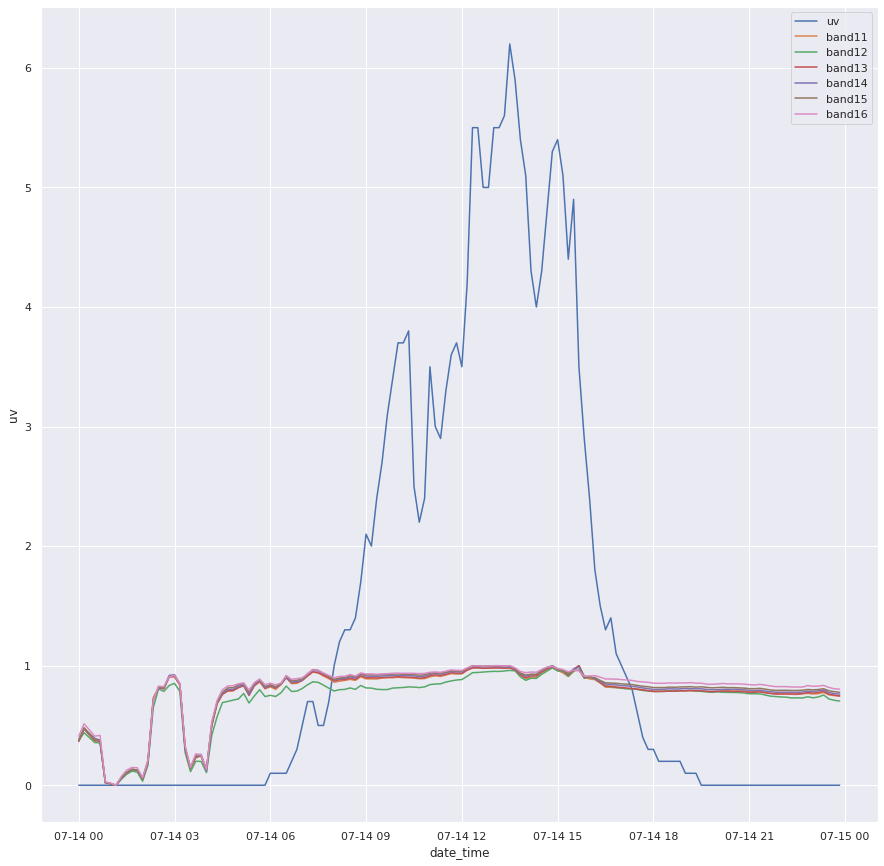

In [ ]:
sns_data = pps(df_108['2020-07-14 00:00:00' : '2020-07-14 23:50:00'],'minmax') #비,소나기 박무
plt.figure(figsize=(15,15))
for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

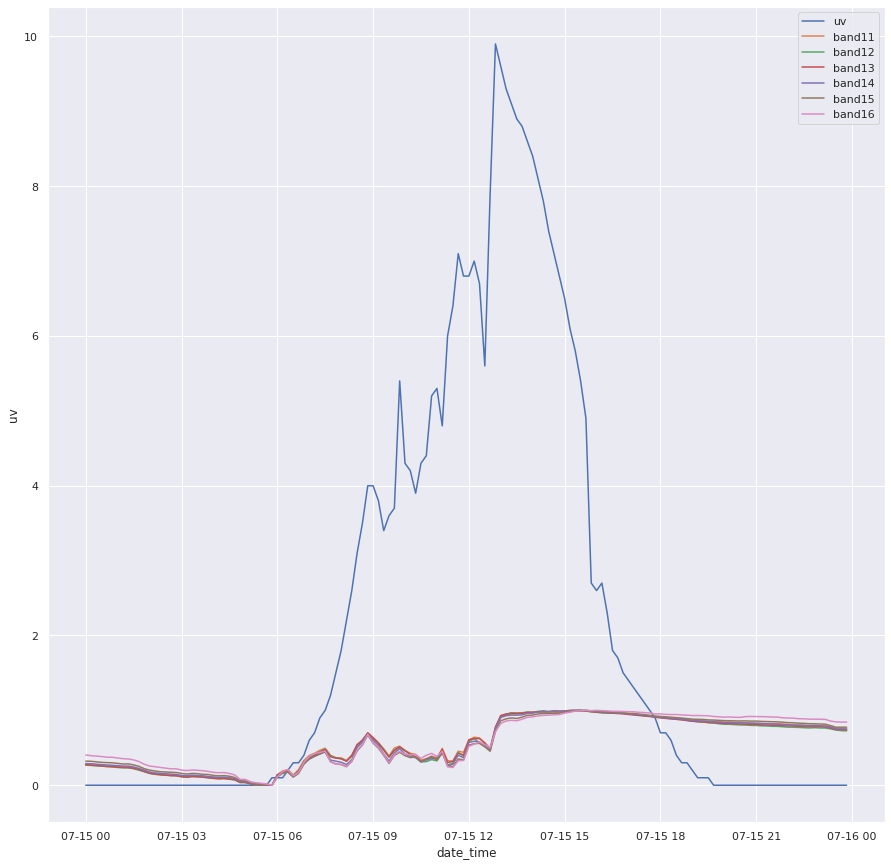

In [ ]:
sns_data = pps(df_108['2020-07-15 00:00:00' : '2020-07-15 23:50:00'],'minmax') #맑음
plt.figure(figsize=(15,15))
for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

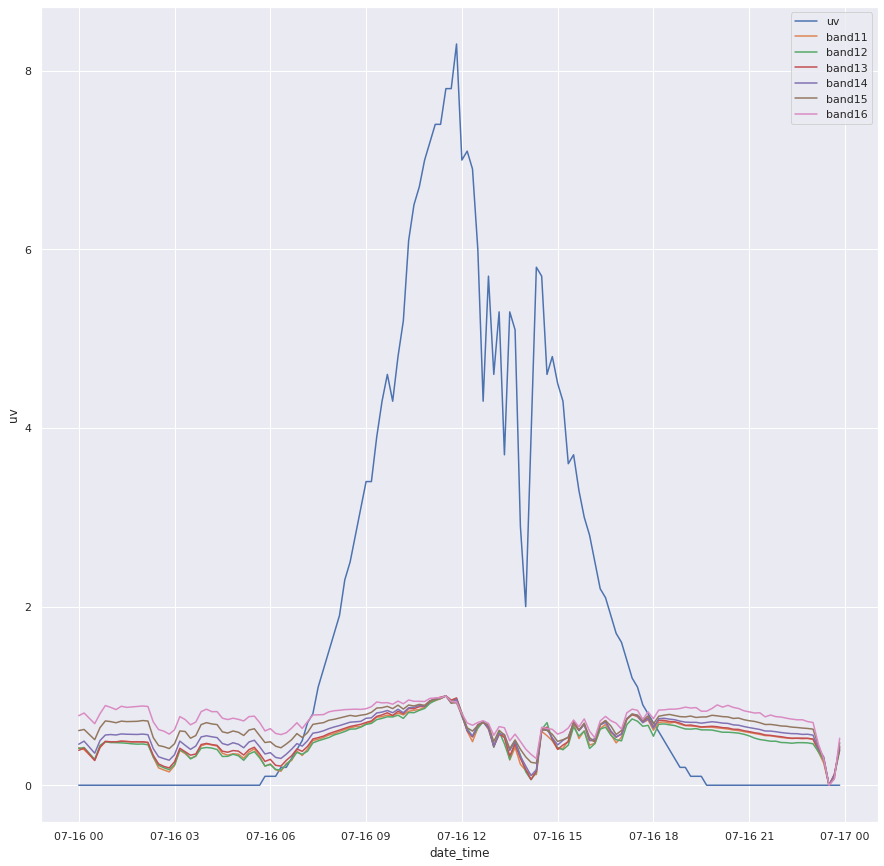

In [ ]:
sns_data = pps(df_108['2020-07-16 00:00:00' : '2020-07-16 23:50:00'],'minmax') #맑음
plt.figure(figsize=(15,15))

for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

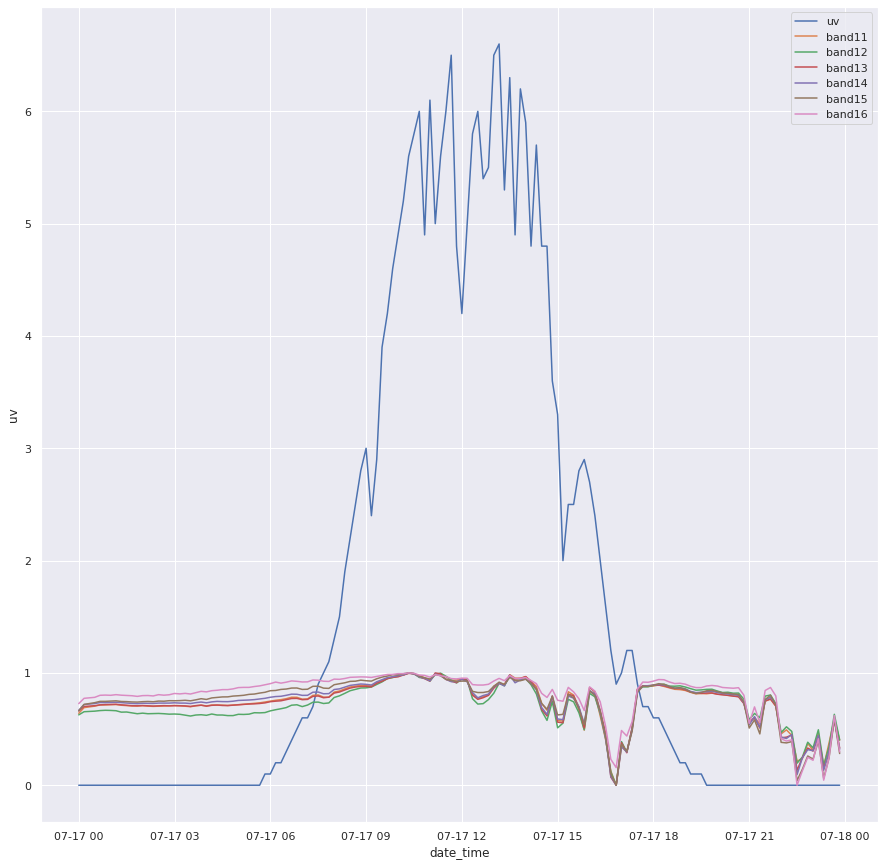

In [ ]:
sns_data = pps(df_108['2020-07-17 00:00:00' : '2020-07-17 23:50:00'],'minmax') #비 연무
plt.figure(figsize=(15,15))

for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

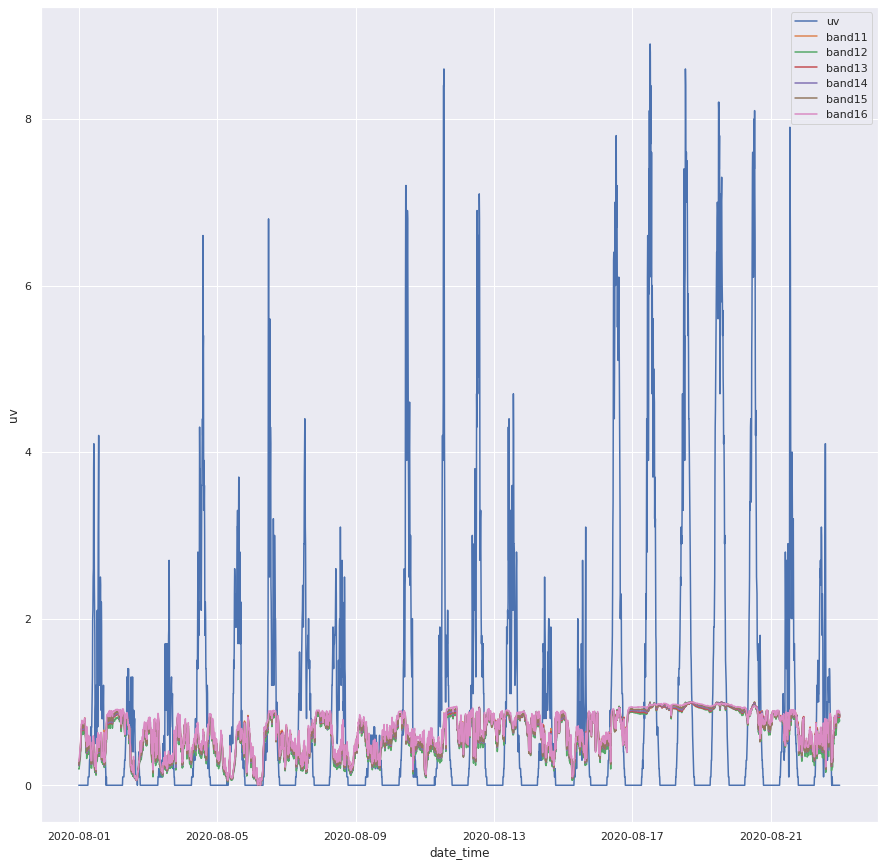

In [ ]:
sns_data = pps(df_108['2020-08-01 00:00:00' : '2020-08-22 23:50:00'],'minmax') 
plt.figure(figsize=(15,15))

for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

In [ ]:
sns.pairplot(pps(df_108,'standard').loc[:,col_list])#sdsd

Output hidden; open in https://colab.research.google.com to view.